In [1]:
import numpy as np
import pandas as pd
import scipy.stats

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

In [4]:
mydf = pd.read_csv('dataset/svi.csv')

In [5]:
mydf.head()

,STATEFP,COUNTYFP,TRACTCE_x,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,year,tract,deaths,geometry,TRACTCE_y,theme_1_pctile,theme_2_pctile,theme_3_pctile,theme_4_pctile,svi_pctile
0,25,17,333300,25017333300,3333.00,Census Tract 3333,G5020,S,1627185,436948,...,2000,NaN,0.0,"POLYGON ((-71.161392 42.470706, -71.161356 42....",333300.0,0.4146,0.38862,0.48222,0.48178,0.4466
1,25,17,333400,25017333400,3334.00,Census Tract 3334,G5020,S,4883574,62527,...,2000,333400.0,1.0,"POLYGON ((-71.146903 42.480766, -71.146726 42....",333400.0,0.3776,0.39834,0.39406,0.41304,0.3770
2,25,17,333502,25017333502,3335.02,Census Tract 3335.02,G5020,S,1443446,0,...,2000,NaN,0.0,"POLYGON ((-71.159602 42.48482, -71.159536 42.4...",333502.0,0.6760,0.39660,0.63420,0.68060,0.6690
3,25,17,354500,25017354500,3545.00,Census Tract 3545,G5020,S,334459,0,...,2000,NaN,0.0,"POLYGON ((-71.130771 42.38261, -71.130696 42.3...",354500.0,0.2540,0.01760,0.50770,0.70050,0.3300
4,25,17,354700,25017354700,3547.00,Census Tract 3547,G5020,S,355374,0,...,2000,NaN,0.0,"POLYGON ((-71.129006 42.390072, -71.127685 42....",354700.0,0.2310,0.03010,0.54230,0.35900,0.2130


In [128]:
smdf = mydf[['NAME', 'year', 'deaths', 'INTPTLAT', 'INTPTLON', 'svi_pctile']].copy()

smdf = smdf.query("year >= 2010").copy()

y12df = smdf.query("year == 2012").copy()
y18df = smdf.query("year == 2018").copy()

In [129]:
smdf['y'] = smdf['INTPTLAT'].values - np.mean(smdf['INTPTLAT'].values)
smdf['x'] = smdf['INTPTLON'].values - np.mean(smdf['INTPTLON'].values)

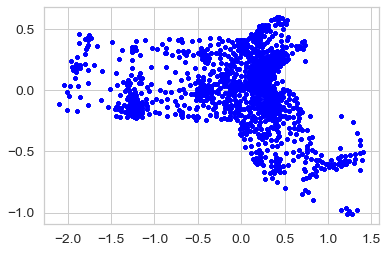

In [130]:
plt.plot(smdf['x'], smdf['y'], 'b.')

In [83]:
(y18df['NAME'].values == 3549.01).sum()

1

In [111]:
ref_locations = [
    ('N. Cambridge', 3549.01),
    ('Arlington', 3564),
    ('Springfield', 8019.02),
    ('Pittsfield', 9001),
    ('Brockton', 5107),
    ('Lawrence', 2501.00),
    ('Nantucket', 9504.00),
    ('Falmouth', 146.00),
]

In [124]:
n_neighbors = 20

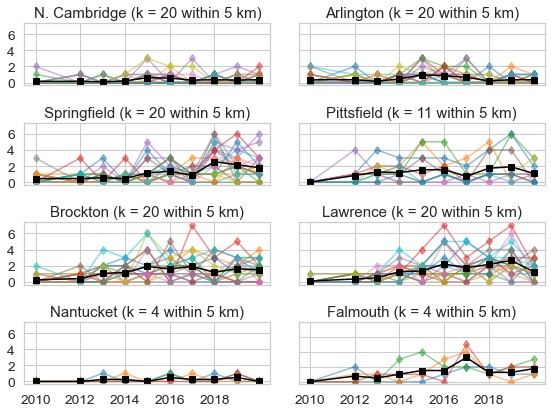

In [125]:
from sklearn.metrics.pairwise import haversine_distances

N = y18df.shape[0]
lat_lon_in_rad_N2 = np.radians(np.hstack([
    y18df['INTPTLAT'].values[:,np.newaxis],
    y18df['INTPTLON'].values[:,np.newaxis]]))

nrows = len(ref_locations)//2
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=2, figsize=(nrows * 2, 2 * 3), sharex=True, sharey=True)

axes = axes.flatten()
aa = 0
for name, tract in ref_locations:

    best_id = np.flatnonzero(y18df['NAME'].values == tract)[0]

    angdist_from_ref_N = haversine_distances(
        lat_lon_in_rad_N2,
        lat_lon_in_rad_N2[best_id:best_id+1])[:,0]

    # multiply by Earth radius to get kilometers
    km_dist_N = angdist_from_ref_N * 6371000/1000

    # Keep at most 20 closest census tracts within 5 km
    keep_ids = np.argsort(km_dist_N)[:n_neighbors]
    keep_ids = keep_ids[km_dist_N[keep_ids] < 5]
    keep_tracts = y18df['NAME'].values[keep_ids].tolist()

    q_df = smdf.query("NAME == @keep_tracts").copy()
    mean_df = q_df.groupby('year').mean()
    mean_df['year'] = mean_df.index

    for tract in keep_tracts:
        tmpdf = q_df.query("NAME == %s" % tract).copy()
        axes[aa].plot(tmpdf.year, tmpdf['deaths'], 'd-', alpha=0.5)

    axes[aa].plot(mean_df['year'], mean_df['deaths'], 'ks-')
    axes[aa].set_title(name + " (k = %d within 5 km)" % (len(keep_tracts)))
    aa += 1
plt.tight_layout()

plt.xticks(np.arange(2010, 2020, 2));
plt.yticks(np.arange(0, 10, 2));

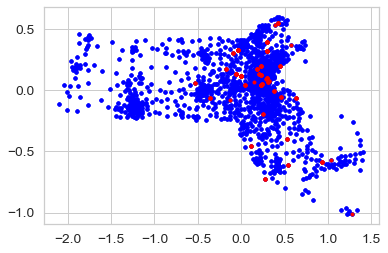

In [137]:
badids = np.flatnonzero(smdf['svi_pctile'].values < 0.02)

plt.plot(smdf['x'], smdf['y'], 'b.', alpha=0.4)
plt.plot(smdf['x'].values[badids], smdf['y'].values[badids], 'r.')